<h2 style='color:blue' align='center'>Lung and Colon Cancer Histopathological Images Classification Using Convolutional Neural Network (CNN)</h2>

<img src="small_images.jpg" />

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import os

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [2]:
pip install split-folders

<h4 style="color:purple">Load the dataset</h4>

In [3]:
import splitfolders
import os
path = r"C:\Users\Lenovo\Downloads\archive(2)\lung_colon_image_set"
print(os.listdir(path))

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [4]:
splitfolders.ratio(path,seed=1337, output="Colon-Splitted", ratio=(0.9, 0.05, 0.05))

Copying files: 25000 files [01:43, 241.95 files/s]


In [5]:
BATCH_SIZE = 25
DATA_DIRT = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\train")
DATA_DIRTE = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\test")
DATA_DIRV = (r"C:\Users\Lenovo\Downloads\Colon-Splitted\val")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
class_details = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRT,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRV,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    
    
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIRTE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,

    
)


def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label


def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds=validation_ds.map(process)
testing_ds=testing_ds.map(process)


Found 22500 files belonging to 5 classes.
Found 5000 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.


In [6]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE



def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=30,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history

def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

## InceptionV3

In [7]:
pretrained_inception_v3_base=tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    pooling="avg"
)
pretrained_inception_v3_base.trainable = False


inception_v3_modell = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.inception_v3.preprocess_input),
    pretrained_inception_v3_base,
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(5, activation="softmax")
])
inception_v3_modell.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 23117093 (88.18 MB)
Trainable params: 1314309 (5.01 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


Epoch 1/30
900/900 [==============================] - 1089s 1s/step - loss: 0.7615 - accuracy: 0.6703 - val_loss: 0.5271 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 2/30
900/900 [==============================] - 1625s 2s/step - loss: 0.5390 - accuracy: 0.7743 - val_loss: 0.4997 - val_accuracy: 0.8008 - lr: 0.0010
Epoch 3/30
900/900 [==============================] - 1632s 2s/step - loss: 0.4872 - accuracy: 0.7984 - val_loss: 0.4202 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 4/30
900/900 [==============================] - 1675s 2s/step - loss: 0.4590 - accuracy: 0.8098 - val_loss: 0.3774 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 5/30
900/900 [==============================] - 1652s 2s/step - loss: 0.4378 - accuracy: 0.8190 - val_loss: 0.4187 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 6/30
900/900 [==============================] - 1624s 2s/step - loss: 0.4214 - accuracy: 0.8278 - val_loss: 0.3434 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 7/30
900/900 [==============================] - 1976

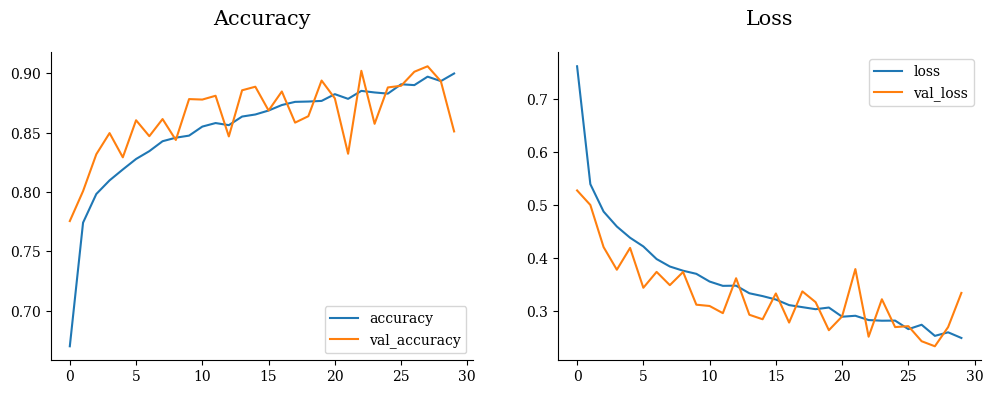

In [8]:
inception_v3_history = compile_and_fit_model(inception_v3_modell)

In [9]:
score =inception_v3_modell.evaluate(testing_ds, steps = len(testing_ds)/BATCH_SIZE, verbose = 0)
print('test loss:', score[0])
print('test accuracy:', score[1])

test loss: 0.2988753318786621
test accuracy: 0.8799999952316284
